In [1]:
import os
import glob
import pandas as pd
import lpips
import math
import plotly.express as px
import numpy as np
from natsort import natsorted
import cv2
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
loss_fn_alex = lpips.LPIPS(net='alex')
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:
images_dir = '/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/Images'
data_path = '/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data'
gt_fol = os.path.join(data_path, "GT_N")

In [4]:
def get_mAP(targets, preds):
    APs = np.zeros(preds.shape[1])
    APs2 = np.zeros(preds.shape[1])
    ARs = np.zeros(preds.shape[1])
    F1s = np.zeros(preds.shape[1])
    ACCs = np.zeros(preds.shape[1])
    for k in range(preds.shape[1]):
        APs[k], ARs[k], F1s[k], ACCs[k] = _average_precision_2(targets[:, k], preds[:, k])
        APs2[k] = _average_precision(targets[:, k], preds[:, k])

    return APs, ARs, F1s, ACCs, APs2

def _average_precision(output, target):
    # print(output, target)
    epsilon = 1e-8

    # sort examples
    indices = output.argsort()[::-1]
    # Computes prec@i
    total_count_ = np.cumsum(np.ones((len(output), 1)))

    target_ = target[indices]

    ind = target_ == 1

    pos_count_ = np.cumsum(ind)

    total = pos_count_[-1]
    pos_count_[np.logical_not(ind)] = 0

    pp = pos_count_ / total_count_
    precision_at_i_ = np.sum(pp)
    # print(pp, precision_at_i_, pos_count_, total_count_)
    precision_at_i = precision_at_i_ / (total + epsilon)

    return precision_at_i


def _average_precision_2(target, output):
    epsilon = 1e-8

    total_pred_pos = np.count_nonzero(output)
    total_target_pos = np.count_nonzero(target)

    TP = np.count_nonzero(np.logical_and(output, target))
    TN = np.count_nonzero(np.logical_and(np.logical_not(output), np.logical_not(target)))
    FP = total_pred_pos - TP
    FN = total_target_pos - TP

    AP = TP / (TP + FP + epsilon)
    AR = TP / (TP + FN + epsilon)
    F1 = (2 * AP * AR) / (AP + AR + epsilon)
    ACC = (TP + FP) / (TP + TN + FP + FN + epsilon)

    return AP, AR, F1, ACC


def calculate_model_map(gt_path, gt_files, pred_path, obj_list=None):
    gt_dict = {}
    pred_dict = {}

    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        gt_data = pd.read_csv(gt_fl)
        gt_data.replace(-1, 1, inplace=True)
        x = []
        for index, row in gt_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in gt_dict.keys():
                gt_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                gt_dict[list(row)[0].strip().lower()] = list(row)[1:]

            x.append(len(list(row)[1:]))

        y = []
        pred_data = pd.read_csv(pred_fl)
        pred_data.replace(-1, 1, inplace=True)
        for index, row in pred_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in pred_dict.keys():
                pred_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                pred_dict[list(row)[0].strip().lower()] = list(row)[1:]
            y.append(len(list(row)[1:]))

        if x != y:
            print(len(x), len(y), fl)

    target_array = []
    pred_array = []

    label_names = []

    for key in gt_dict.keys():
        if key in pred_dict.keys():
            if obj_list:
                if key not in obj_list:
                    continue
            if len(gt_dict[key]) == len(pred_dict[key]):
                target_array.append(gt_dict[key])
                pred_array.append(pred_dict[key])
                label_names.append(key)
            else:
                print(len(gt_dict[key]), len(pred_dict[key]), key)
    
    target_array = np.array(target_array).T
    pred_array = np.array(pred_array).T

    try:
        precs = precision_score(target_array, pred_array, average="micro")
    except Exception as e:
        # ap = 0
        print(e)
        precs = 0.0

    return precs

In [5]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform_f = transforms.ToTensor()

def normalize_image(in_img):
    pixels = np.asarray(in_img).astype('float32')
    pixels = (pixels - mean) / std
    return pixels

In [218]:
def get_steady_state_probabilities_ifs(pred, img_dir, vid_n, seg_n):
    pred = pred.T
    # unq_st = np.unique(pred, axis=0)
    unq_st = []
    for p_ in pred:
        pppp = list(p_)
        if pppp not in unq_st:
            unq_st.append(pppp)

    unq_st = np.array(unq_st)
            
    unq_st_str = []
    for x in unq_st:
        str_bit = [str(ch) for ch in x]
        unq_st_str.append(''.join(str_bit))

    # print(unq_st[0].shape[0])
    # for x in range(2**(unq_st[0].shape[0])):
    #     str_bit = str(bin(x)).replace('0b', '').zfill(unq_st[0].shape[0])
    #     unq_st_str.append(str_bit)

    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        # if f == 1:
        #     init_state = ''.join([str(ch) for ch in pred[f-1]])
        # s_prev = ''.join([str(ch) for ch in pred[f-1]])
        f_now_pth = os.path.join(img_dir, f'video-{vid_n}-segment-{seg_n}-frame-{f}.jpeg')
        f_prev_pth = os.path.join(img_dir, f'video-{vid_n}-segment-{seg_n}-frame-{f-1}.jpeg')

        image_now = cv2.resize(normalize_image(np.array(Image.open(
            f_now_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
        image_prev = cv2.resize(normalize_image(np.array(Image.open(
            f_prev_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)

        img0 = transform_f(image_now).unsqueeze(0)
        img1 = transform_f(image_prev).unsqueeze(0)

        # if f == 1:
        #     transition_matrix[s_prev][s_prev] = 1

        # if s_prev == s_now:
        #     transition_matrix[s_prev][s_prev] = 1
        # else:
        #     d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]
        #     transition_matrix[s_prev][s_prev] += (1.0*d)
        #     transition_matrix[s_now][s_prev] += (1.0*(1-d))
        #     if d < 0.5:
        #         init_state = ''.join([str(ch) for ch in pred[f]])

        d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]
        # print(d, os.path.basename(f_now_pth), os.path.basename(f_prev_pth))

        # if s_now == s_prev:
        #     transition_matrix[init_state][init_state] += (1.0*d)
        #     transition_matrix[init_state][init_state] += (1.0*(1-d))
        # else:
        #     transition_matrix[s_now][init_state] += (1.0*(1-d))
        #     transition_matrix[init_state][init_state] += (1.0*d)
            
        #     if d < 0.5:
        #         init_state = ''.join([str(ch) for ch in pred[f]])

        transition_matrix[s_prev][s_prev] += (1.0*d)
        transition_matrix[s_now][s_prev] += (1.0*(1-d))

        # if d < 0.5:
        #     init_state = ''.join([str(ch) for ch in pred[f]])

        
        # print(d, s_prev, s_now)

    # p_s_ifs = list(transition_matrix.sum())
    transition_matrix = np.array(transition_matrix)

    # print(transition_matrix)

    N_t_s = transition_matrix.sum(axis=1)
    alpha = 1e-3
    d_ps = N_t_s.shape[0]
    
    # tmx_shape = transition_matrix.shape
    # transition_matrix = transition_matrix.reshape((tmx_shape[0] * tmx_shape[1]))
    # N_t = transition_matrix.sum()
    # alpha = 1e-3
    # d = transition_matrix.shape[0]
    # transition_matrix = (transition_matrix + alpha) * (N_t / (N_t + (alpha * d)))
    # transition_matrix = transition_matrix / np.sum(transition_matrix)
    # transition_matrix = transition_matrix.reshape(tmx_shape)
    
    for ind, row in enumerate(transition_matrix):
        new_row = (row + alpha) * (N_t_s[ind] / (N_t_s[ind] + (alpha * d_ps)))
        new_row = new_row / (np.sum(new_row) + 1e-20)
        transition_matrix[ind] = new_row
        
        # transition_matrix.loc[ind] = row
    # p_s_ifs = [ccc/sum(p_s_ifs) for ccc in p_s_ifs]

    I = np.identity(transition_matrix.shape[0])
    P_I = transition_matrix - I
    co_eff = P_I.T

    # co_eff[co_eff.shape[0]-1] =  np.ones((co_eff.shape[1]))
    # const = np.array([0.0 for _ in range(co_eff.shape[0])])
    # const[const.shape[0]-1] = 1.0
    co_eff[0] =  np.ones((co_eff.shape[1]))
    const = np.array([0.0 for _ in range(co_eff.shape[0])])
    const[0] = 1.0

    try:
        p_s_ifs = np.linalg.solve(co_eff, const)
    except:
        print(det(co_eff), vid_n, seg_n)
        p_s_ifs = np.linalg.solve(co_eff, const)

    p_s_ifs = list(p_s_ifs)
    # print(p_s_ifs)
    for s_ind in range((2**(unq_st[0].shape[0]))-len(p_s_ifs)):
        p_s_ifs.append(0.0)

    p_s_ifs = np.array(p_s_ifs)
    
    return p_s_ifs

In [219]:
def get_steady_state_probabilities_ifs_2(pred, img_dir, vid_n, seg_n):
    pred = pred.T
    unq_st = np.unique(pred, axis=0)
    unq_st_str = []
    for x in unq_st:
        str_bit = [str(ch) for ch in x]
        unq_st_str.append(''.join(str_bit))

    # print(unq_st[0].shape[0])
    # for x in range(2**(unq_st[0].shape[0])):
    #     str_bit = str(bin(x)).replace('b', '').zfill(8)
    #     unq_st_str.append(str_bit)


    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        if f == 1:
            init_state = ''.join([str(ch) for ch in pred[f-1]])
        # s_prev = ''.join([str(ch) for ch in pred[f-1]])
        f_now_pth = os.path.join(img_dir, f'video-{vid_n}-segment-{seg_n}-frame-{f}.jpeg')
        f_prev_pth = os.path.join(img_dir, f'video-{vid_n}-segment-{seg_n}-frame-{f-1}.jpeg')

        image_now = cv2.resize(normalize_image(np.array(Image.open(
            f_now_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
        image_prev = cv2.resize(normalize_image(np.array(Image.open(
            f_prev_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)

        img0 = transform_f(image_now).unsqueeze(0)
        img1 = transform_f(image_prev).unsqueeze(0)

        if f == 1:
            transition_matrix[s_prev][s_prev] = 1

        if s_prev == s_now:
            transition_matrix[s_prev][s_prev] = 1
        else:
            d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]
            transition_matrix[s_prev][s_prev] += (1.0*d)
            transition_matrix[s_now][s_prev] += (1.0*(1-d))
            if d < 0.5:
                init_state = ''.join([str(ch) for ch in pred[f]])

        # d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]
        # print(d, os.path.basename(f_now_pth), os.path.basename(f_prev_pth))

        # if s_now == s_prev:
        #     transition_matrix[init_state][init_state] += (1.0*d)
        #     transition_matrix[init_state][init_state] += (1.0*(1-d))
        # else:
        #     transition_matrix[s_now][init_state] += (1.0*(1-d))
        #     transition_matrix[init_state][init_state] += (1.0*d)
            
        #     if d < 0.5:
        #         init_state = ''.join([str(ch) for ch in pred[f]])

        # transition_matrix[s_prev][s_prev] += (1.0*d)
        # transition_matrix[s_now][s_prev] += (1.0*(1-d))

        # if d < 0.5:
        #     init_state = ''.join([str(ch) for ch in pred[f]])

        
        # print(d, s_prev, s_now)

    p_s_ifs = list(transition_matrix.sum())
    # for ind, row in transition_matrix.iterrows():
        # row = row/(row.sum()+1e-15)
        # transition_matrix.loc[ind] = row
    p_s_ifs = [ccc/sum(p_s_ifs) for ccc in p_s_ifs]

    # transition_matrix = np.array(transition_matrix)

    # I = np.identity(transition_matrix.shape[0])
    # P_I = transition_matrix - I
    # co_eff = P_I.T

    # co_eff[co_eff.shape[0]-1] =  np.ones((co_eff.shape[1]))
    # const = np.array([0.0 for _ in range(co_eff.shape[0])])
    # const[const.shape[0]-1] = 1.0

    # try:
    #     p_s_ifs = np.linalg.solve(co_eff, const)
    # except:
    #     print(det(co_eff), vid_n, seg_n)
    #     p_s_ifs = np.linalg.solve(co_eff, const)

    # p_s_ifs = list(transition_matrix.sum())
    # print(p_s_ifs)
    for s_ind in range((2**(unq_st[0].shape[0]))-len(p_s_ifs)):
        p_s_ifs.append(0.0)

    p_s_ifs = np.array(p_s_ifs)
    
    return p_s_ifs

In [220]:
def get_steady_state_probabilities_ifs_3(pred, img_dir, vid_n, seg_n):
    pred = pred.T
    unq_st = np.unique(pred, axis=0)
    unq_st_str = []
    for x in unq_st:
        str_bit = [str(ch) for ch in x]
        unq_st_str.append(''.join(str_bit))

    unq_st_and_count = {}

    # print(unq_st[0].shape[0])
    # for x in range(2**(unq_st[0].shape[0])):
    #     str_bit = str(bin(x)).replace('b', '').zfill(8)
    #     unq_st_str.append(str_bit)


    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        if f == 1:
            init_state = ''.join([str(ch) for ch in pred[f-1]])
        # s_prev = ''.join([str(ch) for ch in pred[f-1]])
        f_now_pth = os.path.join(img_dir, f'video-{vid_n}-segment-{seg_n}-frame-{f}.jpeg')
        f_prev_pth = os.path.join(img_dir, f'video-{vid_n}-segment-{seg_n}-frame-{f-1}.jpeg')

        image_now = cv2.resize(normalize_image(np.array(Image.open(
            f_now_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
        image_prev = cv2.resize(normalize_image(np.array(Image.open(
            f_prev_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)

        img0 = transform_f(image_now).unsqueeze(0)
        img1 = transform_f(image_prev).unsqueeze(0)

        if f == 1:
            if init_state not in unq_st_and_count.keys():
                unq_st_and_count[init_state] = 0
            unq_st_and_count[init_state] += 1

        if s_prev == s_now:
            u_s = init_state
        else:
            d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]
            
            if d < 0.3:
                u_s = s_now
                init_state = ''.join([str(ch) for ch in pred[f]])
            else:
                u_s = init_state


        if u_s not in unq_st_and_count.keys():
            unq_st_and_count[u_s] = 0
        unq_st_and_count[u_s] += 1

    p_s_n = np.array(list(unq_st_and_count.values()))
    
    p_s_ifs = list(p_s_n)
    p_s_ifs = [ccc/sum(p_s_ifs) for ccc in p_s_ifs]

    for s_ind in range((2**(unq_st[0].shape[0]))-len(p_s_ifs)):
        p_s_ifs.append(0.0)

    p_s_ifs = np.array(p_s_ifs)
    
    return p_s_ifs

In [221]:
def get_steady_state_probabilities(h_m):
    hm = np.array(h_m).T
    unique_states = np.unique(hm, axis=0)
    unq_st_and_count = {}
    for i, u_s in enumerate(unique_states):
        c = np.argwhere(np.all(hm == u_s, axis=-1)).shape[0]
        unq_st_and_count[i] = {
            'val': u_s,
            'count': c,
            'ss_prob': c/hm.shape[0]
        }

    p_s_n = np.array([unq_st_and_count[k]['ss_prob'] for k in unq_st_and_count.keys()])
    
    p_s_n = list(p_s_n)
    for s_ind in range((2**(unique_states[0].shape[0]))-len(p_s_n)):
        p_s_n.append(0.0)

    p_s_n = np.array(p_s_n)

    return p_s_n


def calculate_entropy(ss_probs):
    if len(ss_probs) <= 1:
        return 0.0

    tot_ss_ent = 0

    for prb in ss_probs:
        if prb == 0:
            log_p_ss = 0
        else:
            try:
                log_p_ss = math.log2(prb)
            except:
                log_p_ss = 0.0 # math.log2(prb+1e-15)

        t_ent = - prb * log_p_ss

        tot_ss_ent = tot_ss_ent + t_ent

    tot_ss_ent = tot_ss_ent / math.log2(len(ss_probs))

    return tot_ss_ent

In [222]:
def get_st_p_ent(vid, seg, img_path, objs, model):
    pred_file = os.path.join(
        data_path,
        f'{model}/video-{vid}-segment-{seg}.csv'
    )
    pred_df = pd.read_csv(pred_file)
    pred_df = pred_df.transpose()
    pred_df.columns = pred_df.iloc[0]
    pred_df = pred_df.iloc[1:]
    pred_df.columns = map(str.lower, pred_df.columns)
    if objs is not None:
        pred_df = pred_df.reindex(columns=objs)

    pred_df = pred_df.fillna('0').transpose()

    p_steady_ifs = get_steady_state_probabilities_ifs(np.array(pred_df), images_dir, vid, seg)
    ent_ifs = calculate_entropy(p_steady_ifs)

    p_steady = get_steady_state_probabilities(np.array(pred_df))
    ent = calculate_entropy(p_steady)

    return p_steady, ent, p_steady_ifs, ent_ifs

In [223]:
coco_common_obj = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'traffic signals', 'fire hydrant', 'stop sign',
                   'bench', 'dog', 'chair', 'vegetation']

pfb_common_obj = ['road', 'sidewalk', 'tree', 'vegetation', 'building', 'fence', 'traffic signals',
                  'fire hydrant', 'chair', 'trash on roads', 'trash bins', 'person', 'car', 'motorcycle',
                  'bus']

ram_obj_map = {
    'chair': 'chair',
    'pillar': 'pillar',
    'table': 'table',
    'person': 'person',
    'man': 'person',
    'building': 'building',
    'city street': 'road',
    'curb': 'curb',
    'pavement': 'sidewalk',
    'road': 'road',
    'car': 'car',
    'snow': 'snow',
    'doorway': 'sloped driveway',
    'elevator': 'elevator',
    'rail': 'train tracks',
    'stair': 'stairs',
    'cane': 'white cane',
    'door': 'flush door',
    'fence': 'fence',
    'barrier': 'barrier post',
    'bench': 'bench',
    'sign': 'sign',
    'bin': 'trash bins',
    'pole': 'pole',
    'street vendor': 'street vendor',
    'blind': 'person with a disability',
    'dog': 'dog',
    'escalator': 'escalator',
    'street sign': 'sign post',
    'bus stop': 'bus stop',
    'railway station': 'train platform',
    'tree': 'tree',
    'traffic light': 'traffic signals',
    'tree trunk': 'tree',
    'recycling bin': 'trash bins',
    'train track': 'train tracks',
    'pedestrian': 'person',
    'bus': 'bus',
    'city bus': 'bus',
    'tour bus': 'bus',
    'wall': 'wall',
    'elevator door': 'elevator',
    'bicycle': 'bicycle',
    'crosswalk': 'crosswalk',
    'decker bus': 'bus',
    'motorcycle': 'motorcycle',
    'motorcyclist': 'person',
    'biker': 'person',
    'motorbike': 'motorcycle',
    'warning sign': 'sign',
    'hydrant': 'fire hydrant',
    'school bus': 'bus',
    'vegetation': 'vegetation',
    'fountain': 'fountain'
}

ram_com_obj = list(set(list(ram_obj_map.values())))

print(len(ram_com_obj))

39


In [237]:
gt_dir = gt_fol # "/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/GT_N"

gts = natsorted(os.listdir(gt_dir))

skip_list = [
    "video-10-segment-1.csv", "video-9-segment-2.csv"
]

gts = [x.split('.')[0] for x in gts if x.endswith('.csv') and int(x.split('-')[1])<=16 and x not in skip_list]

# gts = ['video-1-segment-4']

len(gts)

19

In [272]:
all_com = natsorted(list(set(ram_com_obj) & set(coco_common_obj) & set(pfb_common_obj)))
# all_com = all_com[:4]
all_com

['bus',
 'car',
 'chair',
 'fire hydrant',
 'motorcycle',
 'person',
 'traffic signals',
 'vegetation']

In [273]:
models = {
    'GT_N': 'all_com',
    'BLIP': 'all_com',
    'GPV-1': 'all_com',
    'RAM': 'all_com',
    'yolo_v7': 'all_com',
    'HRNet_V2': 'all_com',
    'mask_rcnn': 'all_com',
    'faster_rcnn': 'all_com'
}
# models = {
#     'GT_N': 'all_com',
#     'BLIP': 'all_com',
# }

In [274]:
vid_wise_ent = {
    'Models': gts
}

vid_wise_prec = {
    'Models': gts
}

for model_ in models.keys():
    ents_all_vid = []
    ents_all_vid_normal = []
    ps_all_vid = []

    for gt in gts:
        v_ = int(gt.split('-')[1])
        s_ = int(gt.split('-')[3])
        p_s, e_, p_s_i, e_i = get_st_p_ent(v_, s_, images_dir, eval(models[model_]), model_)

        ents_all_vid.append(e_i)
        ents_all_vid_normal.append(e_)
        p_s_i = list(p_s_i)
        p_s_i =sorted(p_s_i)
        # print(e_i, max(p_s_i), sum(p_s_i), p_s_i[-5:])

        pred_fol = os.path.join(data_path, model_)
        p_ = calculate_model_map(
            gt_fol, [f'{gt}.csv'], pred_fol, 
            obj_list=eval(models[model_])
        )
        ps_all_vid.append(p_)

    
    # if model_ == 'GT_N':
    vid_wise_ent[f"{model_}"] = ents_all_vid
    # vid_wise_ent[f"{model_}"] = ents_all_vid_normal
    # else:  # (without lpips)  (with lpips)
    #     vid_wise_ent[model_] = ents_all_vid
         
    vid_wise_prec[model_] = ps_all_vid


In [275]:
vid_wise_model_ent_df = pd.DataFrame(vid_wise_ent).transpose()
vid_wise_model_ent_df.columns = vid_wise_model_ent_df.iloc[0]
vid_wise_model_ent_df = vid_wise_model_ent_df.iloc[1:]

In [276]:
ssdf = pd.DataFrame(vid_wise_ent) # .sort_values(by=['GT_N (with lpips)'])
for col in list(ssdf.columns)[1:]:
    ssdf[col] = ssdf[col].round(2)
# ssdf['GT_N (without lpips)'] = ssdf['GT_N (without lpips)'].round(2)
ssdf = ssdf.transpose()
ssdf.columns = [f'V{cc.split("-")[1]}S{cc.split("-")[3]}' for cc in ssdf.iloc[0]]
ssdf = ssdf.iloc[1:]

In [277]:
ssdf # .drop(['GT_N (without lpips)', 'HRNet_V2'])

,V1S4,V1S5,V2S1,V3S2,V3S3,V4S1,V4S3,V4S4,V5S1,V6S2,V7S2,V8S2,V11S1,V12S4,V13S2,V14S1,V14S4,V15S3,V16S3
GT_N,0.12,0.02,0.21,0.06,0.02,0.26,0.01,0.18,0.05,0.04,0.23,0.0,0.02,0.03,0.12,0.03,0.0,0.0,0.09
BLIP,0.15,0.02,0.38,0.02,0.3,0.34,0.36,0.28,0.07,0.16,0.33,0.13,0.03,0.09,0.06,0.04,0.34,0.09,0.09
GPV-1,0.13,0.36,0.42,0.18,0.34,0.4,0.28,0.22,0.29,0.31,0.39,0.34,0.22,0.12,0.19,0.31,0.24,0.08,0.16
RAM,0.0,0.17,0.01,0.11,0.11,0.21,0.06,0.07,0.05,0.06,0.2,0.04,0.09,0.13,0.08,0.0,0.12,0.07,0.0
yolo_v7,0.1,0.2,0.18,0.0,0.12,0.24,0.1,0.06,0.03,0.04,0.12,0.09,0.18,0.02,0.03,0.07,0.1,0.01,0.06
HRNet_V2,0.33,0.39,0.47,0.32,0.41,0.34,0.07,0.24,0.26,0.32,0.25,0.1,0.36,0.05,0.29,0.05,0.0,0.15,0.26
mask_rcnn,0.16,0.41,0.45,0.3,0.19,0.31,0.34,0.36,0.22,0.16,0.16,0.38,0.32,0.11,0.13,0.03,0.37,0.27,0.28
faster_rcnn,0.35,0.34,0.37,0.26,0.36,0.32,0.34,0.33,0.22,0.13,0.43,0.34,0.33,0.18,0.3,0.04,0.35,0.32,0.21


In [278]:
vid_wise_model_prec_df = pd.DataFrame(vid_wise_prec).transpose()
vid_wise_model_prec_df.columns = vid_wise_model_prec_df.iloc[0]
vid_wise_model_prec_df = vid_wise_model_prec_df.iloc[1:]

In [297]:
mAP_df = pd.DataFrame(vid_wise_prec)
for col in list(mAP_df.columns)[1:]:
    mAP_df[col] = mAP_df[col].round(2)
# ssdf['GT_N (without lpips)'] = ssdf['GT_N (without lpips)'].round(2)
mAP_df = mAP_df.transpose()
mAP_df.columns = [f'V{cc.split("-")[1]}S{cc.split("-")[3]}' for cc in mAP_df.iloc[0]]
mAP_df = mAP_df.iloc[1:]
mAP_df

,V1S4,V1S5,V2S1,V3S2,V3S3,V4S1,V4S3,V4S4,V5S1,V6S2,V7S2,V8S2,V11S1,V12S4,V13S2,V14S1,V14S4,V15S3,V16S3
GT_N,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BLIP,0.86,0.88,0.72,0.71,0.87,0.85,0.58,0.8,0.77,0.59,0.79,0.56,0.85,0.91,0.89,0.82,0.65,0.94,0.68
GPV-1,0.92,0.62,0.84,0.83,0.73,0.66,0.82,0.71,0.4,0.59,0.76,0.52,0.61,0.89,0.92,0.78,0.69,0.8,0.97
RAM,1.0,0.95,1.0,1.0,1.0,1.0,1.0,0.97,0.96,1.0,1.0,0.95,0.96,1.0,0.92,1.0,1.0,1.0,1.0
yolo_v7,1.0,0.8,0.92,1.0,1.0,1.0,1.0,0.96,0.96,1.0,0.96,0.92,0.88,1.0,0.95,1.0,0.92,0.94,1.0
HRNet_V2,0.76,0.36,0.53,0.53,0.62,0.56,0.63,0.51,0.28,0.48,0.6,0.47,0.49,0.78,0.75,0.68,0.58,0.88,0.76
mask_rcnn,0.78,0.42,0.68,0.64,0.57,0.66,0.76,0.61,0.66,0.7,0.66,0.38,0.51,0.87,0.8,0.68,0.54,0.78,0.82
faster_rcnn,0.72,0.49,0.66,0.75,0.62,0.7,0.8,0.62,0.64,0.8,0.67,0.41,0.54,0.75,0.74,0.65,0.47,0.79,0.76


In [280]:
v_s_ = ['video-3-segment-2']
vid_wise_model_prec_df.reindex(columns=v_s_)

Models,video-3-segment-2
GT_N,1.0
BLIP,0.705882
GPV-1,0.827586
RAM,1.0
yolo_v7,1.0
HRNet_V2,0.531915
mask_rcnn,0.638889
faster_rcnn,0.75


pearson:  PearsonRResult(statistic=-0.45907372158209614, pvalue=0.3001098721937546)
spearman:  SignificanceResult(statistic=-0.6170650134055817, pvalue=0.1399017539828801)
kendall:  SignificanceResult(statistic=-0.47434164902525694, pvalue=0.15374562936335476)


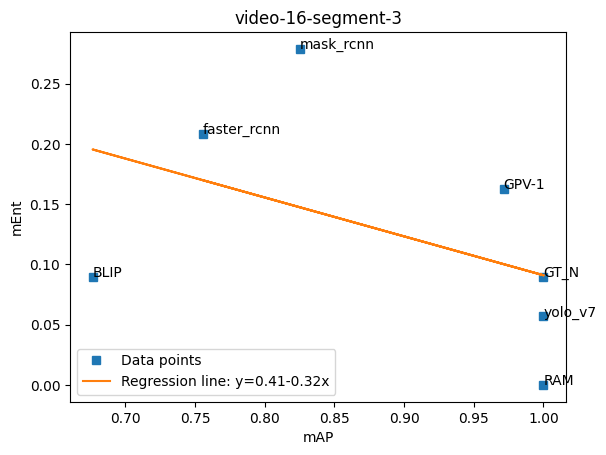

In [281]:
mEnt = {}
v_s_ = ['video-16-segment-3']

for key in dict(vid_wise_model_ent_df.mean(axis='columns')):
    if key in ['HRNet_V2', 'GT_N (without lpips)']: # , 'GT_N (with lpips)'
        continue
    mEnt[key] = dict(vid_wise_model_ent_df.reindex(columns=v_s_).mean(axis='columns'))[key]

mAP = {}

for key in dict(vid_wise_model_prec_df.mean(axis='columns')):
    if key in ['HRNet_V2', 'GT_N (without lpips)']: # , 'GT_N (with lpips)'
        continue
    mAP[key] = dict(vid_wise_model_prec_df.reindex(columns=v_s_).mean(axis='columns'))[key]

x, y = np.array(list(mAP.values())), np.array(list(mEnt.values()))
print("pearson: ", scipy.stats.pearsonr(x, y))
print("spearman: ", scipy.stats.spearmanr(x, y))
print("kendall: ", scipy.stats.kendalltau(x, y))
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}-{abs(slope):.2f}x'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
for i, txt in enumerate(mAP.keys()):
    ax.annotate(txt, (x[i], y[i]))
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('mAP')
ax.set_ylabel('mEnt')
ax.legend(facecolor='white')
# plt.xlim(0.18, 0.7)
# plt.ylim(0.36, 0.55)
plt.title(f"{v_s_[0]}") 
plt.show()

In [282]:
# v_s_ = ['video-16-segment-3']
mEnt = {}
for key in dict(vid_wise_model_ent_df.mean(axis='columns')):
    if key in ['HRNet_V2', 'GT_N (without lpips)']: # , 'GT_N (with lpips)'
        continue
    mEnt[key] = dict(vid_wise_model_ent_df.mean(axis='columns'))[key]

In [283]:
mAP = {
    'GT_N': 1.0,
    'BLIP': 0.79,
    'GPV-1': 0.75,
    'RAM': 0.98,
    'yolo_v7': 0.96,
    'mask_rcnn': 0.64,
    'faster_rcnn': 0.65
}

#     'HRNet_V2': 0.59,

# mF1 = {
#     'BLIP': 0.28,
#     'GPV-1': 0.23,
#     'RAM': 0.24,
#     'yolo_v7': 0.54,
#     'mask_rcnn': 0.41,
#     'faster_rcnn': 0.42
# }

#    'HRNet_V2': 0.36,

pearson:  PearsonRResult(statistic=-0.9703776292682144, pvalue=0.00028548049251477756)
spearman:  SignificanceResult(statistic=-0.8928571428571429, pvalue=0.006807187408935392)
kendall:  SignificanceResult(statistic=-0.8095238095238096, pvalue=0.010714285714285714)


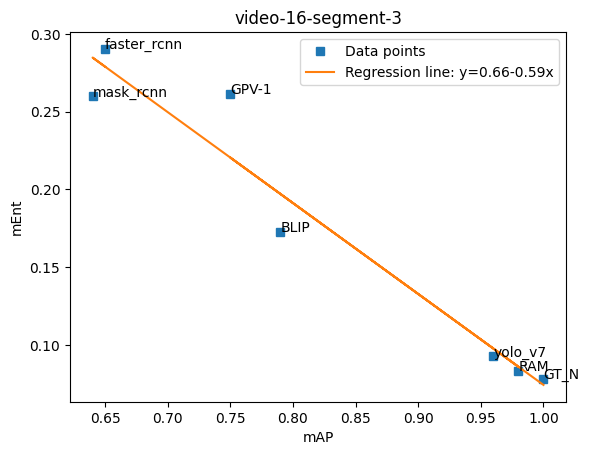

In [284]:
x, y = np.array(list(mAP.values())), np.array(list(mEnt.values()))
print("pearson: ", scipy.stats.pearsonr(x, y))
print("spearman: ", scipy.stats.spearmanr(x, y))
print("kendall: ", scipy.stats.kendalltau(x, y))
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}-{abs(slope):.2f}x'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
for i, txt in enumerate(mAP.keys()):
    ax.annotate(txt, (x[i], y[i]))
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('mAP')
ax.set_ylabel('mEnt')
ax.legend(facecolor='white')
# plt.xlim(0.18, 0.7)
# plt.ylim(0.36, 0.55)
plt.title(f"{v_s_[0]}") 
plt.show()

pearson:  PearsonRResult(statistic=0.046031022482007196, pvalue=0.931002232808767)
spearman:  SignificanceResult(statistic=0.2, pvalue=0.704)
kendall:  SignificanceResult(statistic=0.2, pvalue=0.7194444444444444)


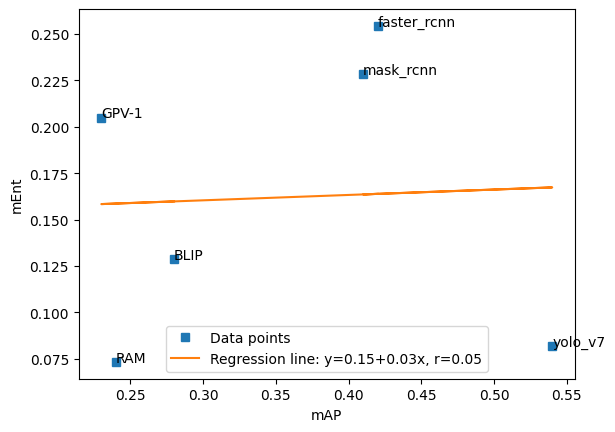

In [364]:
x, y = np.array(list(mF1.values())), np.array(list(mEnt.values()))
print("pearson: ", scipy.stats.pearsonr(x, y))
print("spearman: ", scipy.stats.spearmanr(x, y))
print("kendall: ", scipy.stats.kendalltau(x, y))
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
for i, txt in enumerate(mAP.keys()):
    ax.annotate(txt, (x[i], y[i]))
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('mAP')
ax.set_ylabel('mEnt')
ax.legend(facecolor='white')
# plt.xlim(0.18, 0.7)
# plt.ylim(0.36, 0.55)
plt.show()

In [182]:
import plotly.graph_objects as go

csv_file = "/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/GPV-1/video-3-segment-2.csv"

df = pd.read_csv(csv_file)

df = gpv_df

fig = go.Figure()

colorscale = [
    [0, color_disagreement],
    [1, color_agreement]
]

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Frames", tickmode='linear'),
    yaxis=dict(title_text="Objects",  tickmode='linear'),
    width=1800,
    height=450,
    margin=dict(l=0, r=0, t=40, b=10),
    title=dict(
        text="",
        font=dict(size=32, color="black"),
        x=0.5,
        y=0.995

    )
)

fig.add_trace(
    go.Heatmap(
        z=df,
        x=[i for i, x in enumerate(list(df.columns))],
        y=[x.capitalize() for i, x in enumerate(list(df.index))],
        colorscale=colorscale,
        zmin=-1,
        zmax=1,
        showscale=False
    )
)

fig.update_layout(
    font_family="Courier New, monospace",
    font_color="black",
    title_font_family="Courier New, monospace",
    title_font_color="black",
    legend_title_font_color="black",
    font=dict(size=26),
)

fig.update_xaxes(ticklabelposition='outside')

fig.update_xaxes(
    tickson="boundaries",
    ticklen=5,
    tickangle=0
)
fig.update_layout(
     xaxis=dict(showgrid=True),
     yaxis=dict(showgrid=True)
)

fig.update_layout(xaxis=dict(domain=[0, 1]))
# fig.update_traces(showscale=False)

# fig.update_layout(legend = dict(orientation = "h",
#                                 x=0,
#                                 y=0.5,
#                                 title_font_family="Sitka Small",
#                                 bgcolor="LightBlue",
#                                 bordercolor="Black",
#                                 borderwidth=2))

# fig.update_traces(width=0.4)

# fig.update_traces(colorbar_orientation='h',
#                   colorbar_tickmode='array',
#                   colorbar_ticktext=["can't predict", '0', '1'],
#                   colorbar_tickvals=[-1, 0, 1],
#                   colorbar_tickangle=0,
#                   selector=dict(type='heatmap')
#                  )

# filename = f'{datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")}.pdf'
filename = 'sub_mod_gpv.pdf'

fig.write_image(
    os.path.join(out_plot_path, filename),
    format='pdf'
)

fig

,Object,Frame-0,Frame-1,Frame-2,Frame-3,Frame-4,Frame-5,Frame-6,Frame-7,Frame-8,Frame-9,Frame-10,Frame-11
0,Accent Paving,1,1,1,1,1,1,1,0,1,1,1,1
1,Barrier Post,0,0,0,1,0,0,0,0,0,1,1,1
2,Barrier Stump,0,0,0,0,0,0,0,0,0,1,1,1
3,Bench,0,0,0,0,0,0,0,0,0,0,0,0
4,Bicycle,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Water Pipes,0,0,0,0,1,0,0,0,1,0,1,1
75,Wet surface,0,1,1,0,1,1,1,1,1,1,1,1
76,Wheelchair,0,0,0,1,0,0,1,0,0,1,0,1
77,White Cane,0,0,0,0,0,1,0,0,1,1,1,0


In [238]:
tmx = [
    [9., 1.],
    [1., 9.]
]
tmx = np.array(tmx)

for ind, row in enumerate(tmx):
    tmx[ind] = row/(row.sum()+1e-15)

I__ = np.identity(tmx.shape[0])
p_i__ = tmx - I__
c_eff_ = p_i__.T

c_eff_[0] =  np.ones((c_eff_.shape[1]))
cnst_ = np.array([0.0 for _ in range(c_eff_.shape[0])])
cnst_[0] = 1.0

p_s_ifs__ = np.linalg.solve(c_eff_, cnst_)
p_s_ifs__

array([0.5, 0.5])

In [114]:
(-0.37886598*math.log2(0.37886598)-0.62113402*math.log2(0.62113402))/math.log2(256)

0.1196546450442691

In [44]:
tmx = [
    [0.27, 1.73, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 1.46, 0.83, 0.00, 0.00, 0.00, 0.71, 0.00],
    [0.00, 0.00, 2.53, 0.47, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 8.54, 0.93, 0.53, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.87, 0.13, 0.00, 0.00, 0.00],
    [0.79, 0.00, 0.00, 0.00, 0.00, 2.21, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.53, 0.47],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
]


tmx = np.array(tmx)

# print(tmx.shape)

ones = np.ones(tmx.shape).astype(np.float64) * 1e-5

tmx = tmx

# add 1 to each value


for ind, row in enumerate(tmx):
    tmx[ind] = row/(np.sum(row)+1e-15)

print(tmx)

I__ = np.identity(tmx.shape[0])
p_i__ = tmx - I__
c_eff_ = p_i__.T

c_eff_[0] =  np.ones((c_eff_.shape[1]))
cnst_ = np.array([0.0 for _ in range(c_eff_.shape[0])])
cnst_[0] = 1.0

p_s_ifs__ = np.linalg.solve(c_eff_, cnst_)
p_s_ifs__

[[0.135      0.865      0.         0.         0.         0.
  0.         0.        ]
 [0.         0.48666667 0.27666667 0.         0.         0.
  0.23666667 0.        ]
 [0.         0.         0.84333333 0.15666667 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.854      0.093      0.053
  0.         0.        ]
 [0.         0.         0.         0.87       0.13       0.
  0.         0.        ]
 [0.26333333 0.         0.         0.         0.         0.73666667
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.765      0.235     ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


array([0.05191149, 0.08747424, 0.15447578, 0.45662652, 0.0488118 ,
       0.09190331, 0.08809462, 0.02070224])

In [66]:
calculate_entropy(p_s_ifs__)

0.014497049557582858

In [33]:
tmx = [
    [8.280000004, 0.950000004, 0.570000004],
    [0.090000004, 0.910000004, 0.022000004],
    [0.000000004, 0.000000004, 0.000000004]
]
tmx = np.array(tmx)

for ind, row in enumerate(tmx):
    tmx[ind] = row/(row.sum()+1e-15)

I__ = np.identity(tmx.shape[0])
p_i__ = tmx - I__
c_eff_ = p_i__.T

c_eff_[0] =  np.ones((c_eff_.shape[1]))
cnst_ = np.array([0.0 for _ in range(c_eff_.shape[0])])
cnst_[0] = 1.0

p_s_ifs__ = np.linalg.solve(c_eff_, cnst_)
p_s_ifs__

array([0.4160432 , 0.53052859, 0.05342822])

In [34]:
calculate_entropy(p_s_ifs__)

0.7806771654785365

In [73]:
tmx = [
    [0.27, 1.73, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 1.46, 0.83, 0.00, 0.00, 0.00, 0.71, 0.00],
    [0.00, 0.00, 2.53, 0.47, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 8.54, 0.93, 0.53, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.87, 0.13, 0.00, 0.00, 0.00],
    [0.79, 0.00, 0.00, 0.00, 0.00, 2.21, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.53, 0.47],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00],
]


tmx = np.array(tmx)

print(tmx.sum(axis=1))

tran_mat_shape = tmx.shape

tmx = tmx.reshape((tmx.shape[0] * tmx.shape[1]))
tmx + 6

[ 2.  3.  3. 10.  1.  3.  2.  1.]


array([ 6.27,  7.73,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,
        7.46,  6.83,  6.  ,  6.  ,  6.  ,  6.71,  6.  ,  6.  ,  6.  ,
        8.53,  6.47,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,
       14.54,  6.93,  6.53,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.87,
        6.13,  6.  ,  6.  ,  6.  ,  6.79,  6.  ,  6.  ,  6.  ,  6.  ,
        8.21,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,
        7.53,  6.47,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,
        7.  ])

In [132]:
tmx = tmx.reshape(tran_mat_shape)
tmx + 6

array([[ 6.27,  7.73,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ],
       [ 6.  ,  7.46,  6.83,  6.  ,  6.  ,  6.  ,  6.71,  6.  ],
       [ 6.  ,  6.  ,  8.53,  6.47,  6.  ,  6.  ,  6.  ,  6.  ],
       [ 6.  ,  6.  ,  6.  , 14.54,  6.93,  6.53,  6.  ,  6.  ],
       [ 6.  ,  6.  ,  6.  ,  6.87,  6.13,  6.  ,  6.  ,  6.  ],
       [ 6.79,  6.  ,  6.  ,  6.  ,  6.  ,  8.21,  6.  ,  6.  ],
       [ 6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  7.53,  6.47],
       [ 6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  6.  ,  7.  ]])

In [71]:
tmx = [
    [0.27, 1.73, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 1.46, 0.83, 0.00, 0.00, 0.00, 0.71, 0.00],
    [0.00, 0.00, 2.53, 0.47, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 8.54, 0.93, 0.53, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.87, 0.13, 0.00, 0.00, 0.00],
    [0.79, 0.00, 0.00, 0.00, 0.00, 2.21, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.53, 0.47],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00],
]

tmx = np.array(tmx)
t_matrix_shape = tmx.shape
tmx = tmx.reshape((t_matrix_shape[0] * t_matrix_shape[1]))

N_tmx = tmx.sum()
alpha_tmx = 1e-5
d_tmx = tmx.shape[0]
print(N_tmx, d_tmx)

tmx = (tmx + alpha_tmx) * (N_tmx / (N_tmx + (alpha_tmx * d_tmx)))

print(np.sum(tmx))

tmx = tmx / np.sum(tmx)

tmx = tmx.reshape(t_matrix_shape)

np.sum(tmx)

25.0 64
25.0


0.9999999999999998

In [294]:
tmx = [
    [0.27, 1.73, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 1.46, 0.83, 0.00, 0.00, 0.00, 0.71, 0.00],
    [0.00, 0.00, 2.53, 0.47, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 8.54, 0.93, 0.53, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.87, 0.13, 0.00, 0.00, 0.00],
    [0.79, 0.00, 0.00, 0.00, 0.00, 2.21, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.53, 0.47],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00],
]

tmx = [
    [8.48, 0.95, 0.57],
    [0.90, 0.10, 0.00],
    [0.00, 0.00, 1.00]
]

tmx = [
    [7.13, 0.95, 0.92, 0.00],
    [0.90, 0.10, 0.00, 0.00],
    [0.00, 0.00, 0.43, 0.57],
    [0.00, 0.00, 0.00, 0.00]
]

tmx  = [
    [0.5, 0.5],
    [0.1, 0.9]
]

tmx = np.array(tmx)

N_t_s__ = tmx.sum(axis=1)
print(N_t_s__)
alpha__ = 1e-3
d_ps__ = N_t_s__.shape[0]

# tmx_shape = transition_matrix.shape
# transition_matrix = transition_matrix.reshape((tmx_shape[0] * tmx_shape[1]))
# N_t = transition_matrix.sum()
# alpha = 1e-3
# d = transition_matrix.shape[0]
# transition_matrix = (transition_matrix + alpha) * (N_t / (N_t + (alpha * d)))
# transition_matrix = transition_matrix / np.sum(transition_matrix)
# transition_matrix = transition_matrix.reshape(tmx_shape)

for ind__, row__ in enumerate(tmx):
    new_row__ = (row__ + alpha__) * (N_t_s__[ind__] / (N_t_s__[ind__] + (alpha__ * d_ps__) + 1e-20))
    new_row__ = new_row__ / (np.sum(new_row__) + 1e-20)
    tmx[ind__] = new_row__

print(tmx)

I__ = np.identity(tmx.shape[0])
p_i__ = tmx - I__
c_eff_ = p_i__.T

c_eff_[0] =  np.ones((c_eff_.shape[1]))
cnst_ = np.array([0.0 for _ in range(c_eff_.shape[0])])
cnst_[0] = 1.0

p_s_ifs__ = np.linalg.solve(c_eff_, cnst_)
p_s_ifs__ = list(p_s_ifs__)
print(p_s_ifs__)
# for s_ind in range((2**(8))-len(p_s_ifs__)):
#     p_s_ifs__.append(0.0)
p_s_ifs__ = np.array(p_s_ifs__)
calculate_entropy(p_s_ifs__)

[1. 1.]
[[0.5       0.5      ]
 [0.1007984 0.8992016]]
[0.16777408637873759, 0.8322259136212624]


0.6525874123930399